In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Olist'in Tahmini Teslimat Süresini (ETA) İyileştirme

👉 `Estimated Time of Arrival (ETA)`, modern e-ticaret hizmetlerinin temel bileşenlerinden biridir. Şirketlerin müşteriye teslimat için tahmini bir tarih göstererek beklentileri yönetmesini sağlar.

🎯 Bu çalışmada, bir siparişin `bekleme süresini tahmin eden` bir model kuracağız.

☑️ Olist'in kendi tahminleri `expected_wait_time` değişkeninde zaten mevcut.

🚀 Hadi daha iyi tahminler yapmaya çalışalım ve bu özetin sonunda şunları karşılaştıralım:
* bizim `estimated_wait_time`
* Olist'in `expected_wait_time`
* teslim edilen her sipariş için gerçek `wait_time`

## `orders` veri setini yükle ve kontrol et

👉 `Order().get_training_data()` (`distance_seller_customer` dahil)

In [9]:
import pandas as pd
path = "/home/zeynepdil/code/data-orders/data/"

orders = pd.read_csv(path + "olist_orders_dataset.csv")

orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])

orders = orders[orders["order_status"] == "delivered"]

orders["wait_time"] = (
    orders["order_delivered_customer_date"] - 
    orders["order_purchase_timestamp"]
).dt.days


orders["expected_wait_time"] = (
    orders["order_estimated_delivery_date"] - 
    orders["order_purchase_timestamp"]
).dt.days

In [12]:
orders[["wait_time", "expected_wait_time"]].head(3)

,wait_time,expected_wait_time
0,8.0,15
1,13.0,19
2,9.0,26


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96478 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  object        
 1   customer_id                    96478 non-null  object        
 2   order_status                   96478 non-null  object        
 3   order_purchase_timestamp       96478 non-null  datetime64[ns]
 4   order_approved_at              96464 non-null  object        
 5   order_delivered_carrier_date   96476 non-null  object        
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96478 non-null  datetime64[ns]
 8   wait_time                      96470 non-null  float64       
 9   expected_wait_time             96478 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(1), object(5)
memory usage: 8.1+ MB


## Temel Model - Olist'in mevcut ETA modeli

🐣  Optimize etmek istediğimiz temel seviye (baseline) nedir ❓

👉 Olist'in `expected_wait_time` değeri ile gerçek `wait_time` arasındaki fark

📈 İlgili histogramlarını çiz

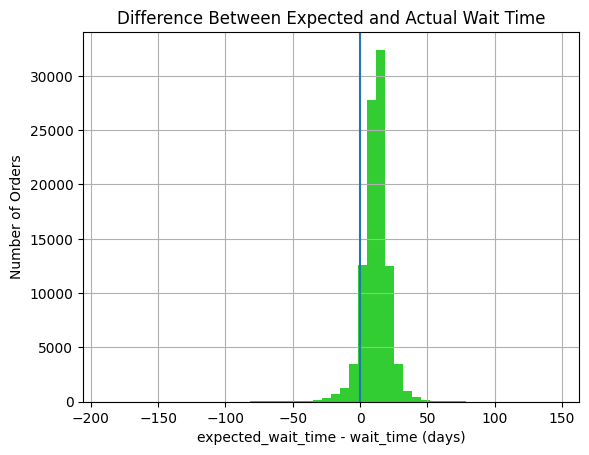

In [16]:
import matplotlib.pyplot as plt
orders["delay_vs_expected"] = (orders["expected_wait_time"]-orders["wait_time"] )
plt.figure()
orders["delay_vs_expected"].hist(bins=50,color="limegreen")

plt.axvline(0)
plt.xlabel("expected_wait_time - wait_time (days)")
plt.ylabel("Number of Orders")
plt.title("Difference Between Expected and Actual Wait Time")

plt.show()


👉 Medyan bekleme süresi nedir? Medyan beklenen bekleme süresi nedir?

In [17]:
print("Real waiting time is: ",orders["wait_time"].median())
print("Expected waiting time is: ",orders["expected_wait_time"].median())

Real waiting time is:  10.0
Expected waiting time is:  23.0


👉 Temel RMSE'yi hesapla

ℹ️ Burada ele alınan hatalar, Olist'in bekleme süresi tahminindeki sapmalarıdır.

In [21]:
time_after_drops = orders[["wait_time", "expected_wait_time"]].dropna()
import numpy as np
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(
    time_after_drops["wait_time"],
    time_after_drops["expected_wait_time"]
))

print("Olist RMSE is:", round(rmse,4))

Olist RMSE is: 15.2019


## OLS çok değişkenli model

👉 Bu sefer `statsmodel.api.OLS` yöntemini kullanarak bir OLS modeli oluşturacağız.

(`statsmodel.formula.api.ols` yerine)

### X özellikleri ve Y hedefi ile veri setini hazırla

In [24]:
orders["purchase_hour"] = orders["order_purchase_timestamp"].dt.hour
orders["purchase_dayofweek"] = orders["order_purchase_timestamp"].dt.dayofweek
orders["purchase_month"] = orders["order_purchase_timestamp"].dt.month

#features = [
    #"purchase_hour",
    #"purchase_dayofweek",
    #"purchase_month"
#]
#X = orders[features]
#y = orders["wait_time"]
data = orders[[
    "wait_time",
    "expected_wait_time",
    "purchase_hour",
    "purchase_dayofweek",
    "purchase_month"
]].dropna()

X = data[[
    "expected_wait_time",
    "purchase_hour",
    "purchase_dayofweek",
    "purchase_month"
]]
y = data["wait_time"]

⚖️ OLS sonucunda elde edilecek regresyon katsayılarını karşılaştırabilmek için X'in her bir özelliğini standartlaştır (`z-score`):

In [25]:
X_standardized = (X - X.mean()) / X.std()

In [28]:
# Check how different is it from the "formula" in statsmodel
#import patsy
import statsmodels.api as sm

X_standardized = sm.add_constant(X_standardized)
model_ols = sm.OLS(y,X_standardized).fit()
print(model_ols.summary())
#patsy.dmatrix('price + distance_seller_customer', orders)

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     4156.
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        20:29:56   Log-Likelihood:            -3.4692e+05
No. Observations:               96470   AIC:                         6.938e+05
Df Residuals:                   96465   BIC:                         6.939e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.0936      0

⚠️ Bu `statsmodel.api.OLS` ile, özellikler veri setine her zaman sabit bir "intercept" (kesme) eklememiz gerekir:

In [ ]:
#already completed at previous step

### `statsmodels` ile OLS'i çalıştır ve `summary` çıktısını yazdır

In [ ]:
# already completed 

## OLS modelinin performansını kontrol et

### Uyum iyiliği (goodness of fit)

👉 En iyi tahminleri kim yapıyor: sen mi, Olist mi?

- Tahminlerini hesapla ve `y_pred` değişkeninde sakla

- Şunları da saklayabilirsin:
    - Olist'in tahminlerini `y_expected_olist` değişkeninde
    - gerçek bekleme sürelerini `y_true` değişkeninde


In [30]:
y_true = data["wait_time"]
y_expected_olist = data["expected_wait_time"]

model = sm.OLS(y_true, X).fit()
y_pred = model.predict(X)

📈 `y_pred`, `y_expected_olist` ve `y_true` değerlerini aynı grafikte çiz.

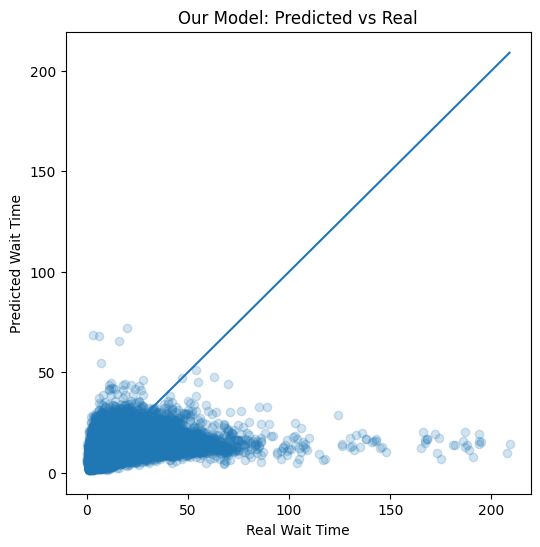

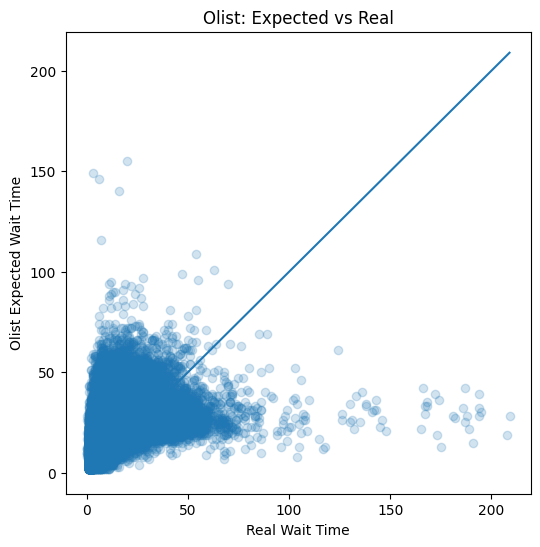

In [36]:
plt.figure(figsize=(6, 6))

plt.scatter(y_true, y_pred, alpha=0.2)
plt.xlabel("Real Wait Time")
plt.ylabel("Predicted Wait Time")
plt.title("Our Model: Predicted vs Real")

plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()])

plt.show()


plt.figure(figsize=(6, 6))

plt.scatter(y_true, y_expected_olist, alpha=0.2)
plt.xlabel("Real Wait Time")
plt.ylabel("Olist Expected Wait Time")
plt.title("Olist: Expected vs Real")

plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()])

plt.show()

👉 Artık hatalar *senin* hataların olacak şekilde RMSE'yi hesapla!

In [34]:
rmse_model = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_olist = np.sqrt(mean_squared_error(y_true, y_expected_olist))

print("Model´s RMSE is:", round(rmse_model,4))
print("Olist´s RMSE is:", round(rmse_olist,4))

Model´s RMSE is: 8.8423
Olist´s RMSE is: 15.2019


Hatırlatma olarak, Olist'in RMSE'si şuna eşitti: 👇

In [ ]:
baseline_RMSE

😏 Gerçekten Olist'in Veri Bilimcilerini yendik mi? Pek de öyle diyemeyiz!

- Birçok e-ticaret ve teslimat servisinde ETA çoğu zaman yüksek tahmin edilir...
- Müşteriler siparişlerini beklenenden erken aldıklarında memnun olma olasılıkları daha yüksektir!

### Kısmi korelasyonlar

👉 `sm.graphics.plot_partregress_grid` ile kısmi korelasyonları görselleştir

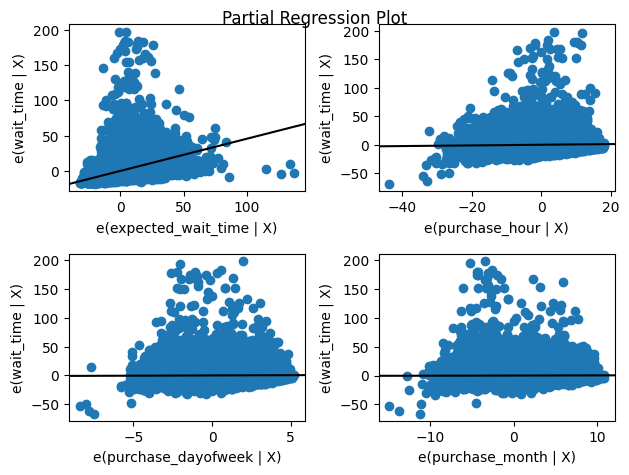

In [38]:
fig_part = sm.graphics.plot_partregress_grid(model)
plt.show()

**Bu grafikleri nasıl okuruz?**

👉 Örneğin sol alt köşedeki grafiğe odaklanalım:

<u>`wait_time` ile `distance` arasındaki kısmi regresyon</u>

- Her nokta veri setimizdeki bir sipariştir


- `y-ekseni`: `distance` hariç tüm özellikleri kullanarak elde edilen `wait_time` artık (residual) değerleri

    - Bu artıklar, `distance` olmadan açıklanamayan `wait_time` hakkındaki kalan bilgiyi içerir


- `x-ekseni`: diğer tüm özellikler (price, freight_value, vb...) kullanılarak `distance` tahmininin artık (residual) değerleri
    - Bu artıklar, modeldeki diğer özelliklerle zaten açıklanmayan ve `distance` değişkeninin getirdiği yeni bilgiyi içerir.


### Çıkarımsal koşullar

⚠️ Artık (residual) değerlerini kontrol et. Normal dağılıma uyuyorlar mı?

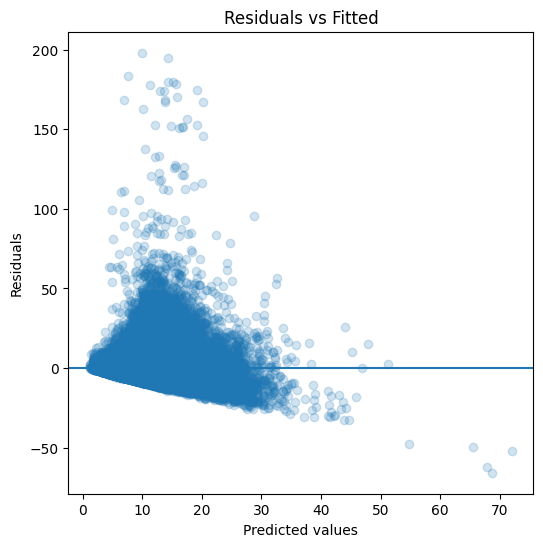

In [39]:
 residuals = y_true - y_pred
 plt.figure(figsize=(6,6))

 plt.scatter(y_pred, residuals, alpha=0.2)
 plt.axhline(0)

 plt.xlabel("Predicted values")
 plt.ylabel("Residuals")
 plt.title("Residuals vs Fitted")

 plt.show()

🎁 Bir dağılımın Gauss (normal) olup olmadığını daha hassas görselleştirmenin bir yolu <a href="https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html">**`QQplot`**</a>'tur.

📈 Aşağıya artık (residual) değerlerinin QQplot'unu çiz.

💡 QQ plot ile az önce çizilen yoğunluk (density) grafiği arasındaki ilişkiyi mutlaka anla..

📚 <a href="https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot">Stats.StackExchange.com - QQplot yorumlama</a>

- `x-axis` : bir Gauss dağılımının teorik kantilleri
- `y-axis`: sıralanmış değişkenin kantilleri

💡 Eğer <span style="color:blue">mavi</span> noktalar, özdeşlik (identity) fonksiyonu olan <span style="color:red">kırmızı çizgi</span> üzerinde hizalanıyorsa, değişken Gauss dağılımına sahiptir!

In [ ]:
sm.qqplot(residuals_lewagon, line='s');

#### Bazı QQplot örnekleri:

QQ plot'ların nasıl çizildiğini anlamak için aşağıdaki hücreleri çalıştır:

In [40]:
from scipy import stats
stats.norm.rvs(0,1)

0.7061765226204704

(-4.7781698613783705, 10.0)

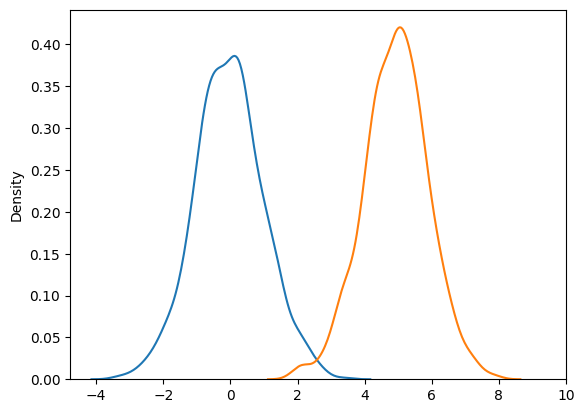

In [42]:
# lets check QQ plots with our own distributions
from scipy import stats
import seaborn as sns
norm_1 = [stats.norm.rvs(0,1) for x in range(1000)]
norm_2 = [stats.norm.rvs(5,1) for x in range(1000)]

sns.kdeplot(norm_1)
sns.kdeplot(norm_2)
plt.xlim(right=10)

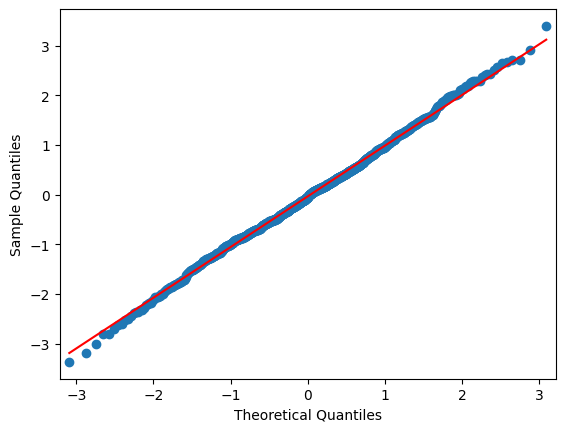

In [43]:
sm.qqplot(np.asarray(norm_1), line='s');

(-5.861203988343151, 10.0)

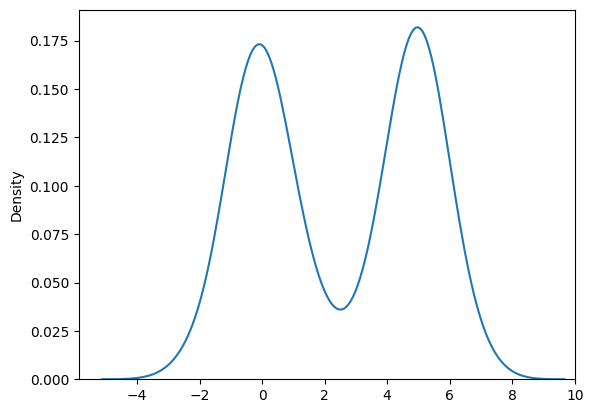

In [44]:
bimodal = norm_1 + norm_2
sns.kdeplot(bimodal)
plt.xlim(right=10)

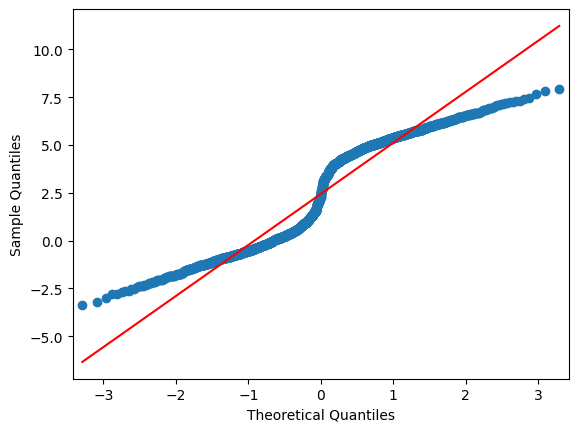

In [45]:
sm.qqplot(np.asarray(bimodal), line='s');

<img src="https://wagon-public-datasets.s3.amazonaws.com/04-Decision-Science/03-Linear-Regression/qq_plot_interpretation.png" width=400>

#### Rastgele olmayan bir desen yakalayıp yakalayamayacağımızı görmek için artıklar (residuals) vs. uyumlanan (fitted) değerleri kontrol et

(0.0, 50.0)

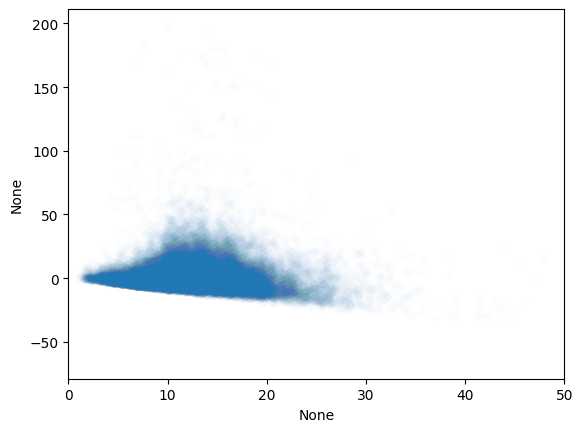

In [47]:
import seaborn as sns
sns.scatterplot(x = y_pred, y = residuals, alpha=0.01)
plt.xlim(xmin=0, xmax=50)

## Daha Fazla Özellik? (Opsiyonel)

Burada ürün detaylarından (boyut, kategori vb.) ek özellikler ekleyebiliriz.

### Her siparişle ilişkili ürün detaylarını ekle (ürün boyutları toplamı, ağırlıklar toplamı vb.)

In [ ]:
from olist.data import Olist
data = Olist().get_data()
products = data['products']
order_items = data['order_items']

In [ ]:
order_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_products

In [ ]:
# Since we want the sum of product weights per order from our new DataFrame, we need to multiply weight by product count
order_items_products['product_weight_g'] = order_items_products['product_weight_g'] *  order_items_products['order_item_count']

order_items_features = order_items_products.groupby("order_id", as_index=False).agg(
    {
        "product_weight_g": "sum",
        "product_length_cm": "max",
        "product_height_cm": "max",
        "product_width_cm": "max",
    }).rename(columns={
        "product_weight_g": "product_weight_g_sum",
        "product_length_cm": "product_length_cm_max",
        "product_height_cm": "product_height_cm_max",
        "product_width_cm": "product_width_cm_max",
    })
order_items_features

In [ ]:
orders_with_details = orders.merge(order_items_features, on="order_id", how="left").dropna()

In [ ]:
X2 = orders_with_details[[
        "number_of_items",
        "number_of_sellers",
        "price",
        "freight_value",
        "distance_seller_customer",
        "product_weight_g_sum",
        "product_length_cm_max",
        "product_height_cm_max",
        "product_width_cm_max"]].copy()
y2 = orders_with_details["wait_time"].copy()

In [ ]:
# standardize (z-normalize) each features of X to compare coefficients
for f in X2.columns:
    mu = X2[f].mean()
    sigma = X2[f].std()
    X2[f] = X2[f].map(lambda x: (x - mu) / sigma)

In [ ]:
X2['constant'] = 1

In [ ]:
model2 = sm.OLS(y2, X2).fit()

In [ ]:
model2.summary()